## Introduction

The art of predicting the future is both magical and mundane. Without some confidence that we can understand the causal dynamics of the cosmos, all attempts at decision-making would be rendered null and void. But the non-linear and chaotic interactions between the universe's varied forces of causation mean that forecasting the behaviour of complex systems in advance can be incredibly difficult [@ELorenz1972].

In this report I describe my attempt to use 942 days of sales data for 1,115 drug stores located across Germany to predict daily sales for the subsequent 6 weeks. For the sake of reproducible research [@RPeng2011], I include all my code in expandable chunks at the appropriate points throughout this text.


In [22]:
import pandas as pd
from pandas import Timestamp
import calendar
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from IPython.display import HTML

In [23]:
## avoid cluttering page with warnings
import warnings; warnings.filterwarnings('ignore')

## The Data

The first step in data analysis is data exploration. The data was given in the form of three CSV files: `stores.csv` contained information for each pseudonymised store regarding their `StoreType`, their `Assortment` of stock, some data about `Competition`, and the store's involvement with an ongoing coupon campaign referred to as `Promo2`; `train.csv` contained daily `Sales` and `Customers` data, including also information as to whether the day was an official `Holiday`, whether the store was `Open` that day, and whether the store was running a store-specific `Promo`; `test.csv` contained identical features, but with `Sales` and `Customers` data removed, so that the forecast can be tested. 

### Parsing Dates

Python's `pandas` library [@WMcKinney2010] for dataframe manipulation provides a powerful set of tools for manipulating dates -- all we have to do is specify which columns should be parsed as such when we load our data. 


In [24]:
training_data = pd.read_csv('../data/raw/train.csv', parse_dates=['Date'])
test_data = pd.read_csv('../data/raw/test.csv', parse_dates=['Date'])

Actually, that is not quite true; for non-standard datetime parsing, we need to use `pd.to_datetime()` after `pd.read_csv()`. This is the case with the dates given for when each store began  experiencing competition, and (separately) participating in `Promo2`.


In [25]:
store_data = pd.read_csv('../data/raw/store.csv',
                        parse_dates={'CompetitionDate':[5,4],
                                     'Promo2Date':[8,7]})

In [26]:
store_data['CompetitionDate'] = pd.to_datetime(
    store_data.CompetitionDate.astype(str), 
    format='%Y %m',
    errors='coerce')

In [27]:
store_data['Promo2Date'] = pd.to_datetime(
    ## we have to insert a dummy 'dayofweek' value (ie. '1')
    ## ... or it won't work
    store_data.Promo2Date.astype(str)+' 1',
    format='%Y %W %w',
    errors='coerce')

### Stores Data: Data Cleaning

On loading the Stores Data, it appeared that there were two unnamed columns in the table -- but this proved to be merely a stray space on the top row. 




In [28]:
with open('../data/raw/store.csv','r') as f:
    txt = f.read().split('\n')
for i, line in enumerate(txt):
    col_11_value = line.split(',')[-1]
    if len(col_11_value)>0:
        print(f'Line {i} had "{col_11_value}" in the final column.')

Line 1 had " " in the final column.


The imposter columns were therefore removed.


In [29]:
store_data.drop(columns=["Unnamed: 11", "Unnamed: 10"], inplace=True)

### Sales Data: Muddled Dates

The Sales Data is supposed to be divided by date into two sets: a training set that goes from the beginning of 2013 until the end of July 2015, and a test set that goes from the start of August 2015. However, inspection suggested both datasets strayed outside these bounds, apparently including data from December 2015. 


In [30]:
print(f'The latest date in `train.csv` is {max(training_data.Date)}.\n'
        + f'The latest date in `test.csv` is {max(test_data.Date)}.')

The latest date in `train.csv` is 2015-12-07 00:00:00.
The latest date in `test.csv` is 2015-12-09 00:00:00.


This was because for all dates where the date of the month was less than or equal to twelve, the day and the month had been reversed, which we can see since the data is otherwise in perfect chronological order (Fig.1). So the first step in data cleaning was iterating through the dates and unmuddling the month and day.


In [31]:
## set number of stores
n = 1115

def disordered_muddle(date_series, future_first=True):
    """Check whether a series of dates is disordered or just muddled"""
    disordered = []
    muddle = []
    dates = date_series
    different_dates = pd.Series(dates.unique())
    date = different_dates[0]
    for i, d in enumerate(different_dates[1:]):
        ## we expect the date's dayofyear to decrease by one
        if d.dayofyear!=date.dayofyear-1:
            ## unless the year is changing
            if d.year!=date.year-1:
                try:
                    ## we check if the day and month are muddled
                    ## if d.day > 12 this will cause an Exception
                    unmuddle = Timestamp(d.year,d.day,d.month)
                    if unmuddle.dayofyear==date.dayofyear-1:
                        muddle.append(d)
                        d = unmuddle
                    elif unmuddle.year==date.year-1:
                        muddle.append(d)
                        d = unmuddle
                    else:
                        disordered.append(d)
                except:
                    disordered.append(d)
        date=d
    if len(disordered)==0 and len(muddle)==0:
        return False
    else:
        return disordered, muddle
    
def unmuddle(date_series, muddled_values):
    """Unmuddle dates where month and day have been confused"""
    date_correction = {}

    for d in date_series:
        if d in muddled_values:
            date_correction[d] = Timestamp(d.year, d.day, d.month)
        else:
            date_correction[d] = Timestamp(d.year, d.month, d.day)

    return date_series.map(date_correction)

In [32]:
disordered, muddle = disordered_muddle(training_data.Date)
_, test_muddle = disordered_muddle(test_data['Date'])

training_data['CorrectedDate'] = unmuddle(training_data['Date'],muddle)
test_data['CorrectedDate'] = unmuddle(test_data['Date'], test_muddle)

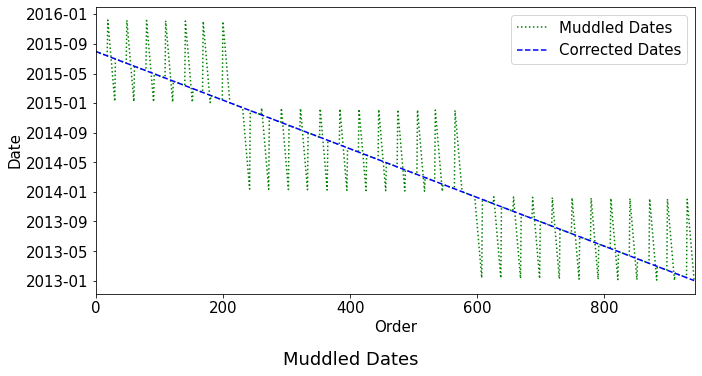

In [33]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(training_data.Date.unique(), label='Muddled Dates',c='green',ls=':')
ax.plot(training_data.CorrectedDate.unique(), label='Corrected Dates',c='blue',ls='--')
ax.legend()
plt.xlim(0,len(training_data.Date.unique()))
plt.xlabel('Order')
plt.ylabel('Date')
fig.suptitle('Muddled Dates', y=0)
fig.savefig('../figures/muddled_dates.png')
plt.tight_layout()
plt.savefig('../figures/muddledates.png')

In [34]:
training_data['Date'] = training_data['CorrectedDate']
training_data.drop(columns=['CorrectedDate'],inplace=True)
test_data['Date'] = test_data['CorrectedDate']
test_data.drop(columns=['CorrectedDate'],inplace=True)

### Sales Data: Missing Dates

Once the dates had been unmuddled, it became clear that 180 stores were missing all dates from the second half of 2014 -- that is, from the 1st July to the 31st December. 


In [35]:
n = len(store_data)
dates_for_store = {}
stores = []

## iterate over Stores and get set of dates for each
for i in range(1, n+1):
    dates_for_store[i] = set(training_data.loc[training_data.Store==i].Date)
    ## I know from further analysis that 758 is the magic number
    ## ... this is for demonstration purposes
    if len(dates_for_store[i]) == 758:
        stores.append(i)

## find missing dates by difference of set of all dates and non-missing dates
non_missing_dates = set()
for i in stores:
    non_missing_dates = non_missing_dates.union(dates_for_store[i])
all_dates = set(training_data['Date'])
missing_dates = all_dates.difference(non_missing_dates)
## show that there are indeed 758 missing dates
assert (len(missing_dates) == len(training_data.Date.unique()) - 758)

## show that the missing dates are an unbroken daily range
start = min(missing_dates)
stop = max(missing_dates)
missing_range = set(pd.date_range(start,stop))
assert missing_dates == missing_range

print(f"""{len(stores)} stores are missing dates \
from {start.strftime("%Y-%m-%d")} to {stop.strftime("%Y-%m-%d")}""")

180 stores are missing dates from 2014-07-01 to 2014-12-31


These 180 stores include stores of all three `Assortment` and all four `StoreType` levels -- there was no clear evidence in the data given of any systematic bias in those stores with missing data. 


In [36]:
stores_missing_dates = store_data.loc[store_data['Store'].isin(stores)]
print(f"""
Stores missing data from second half of 2014 
have `Assortment` values {stores_missing_dates['Assortment'].unique()}
and `StoreType` values {stores_missing_dates["StoreType"].unique()}
 """)


Stores missing data from second half of 2014 
have `Assortment` values ['a' 'c' 'b']
and `StoreType` values ['d' 'a' 'c' 'b']
 


Although we might note that the data does not include geographic information, so a likely scenario would be that they could all be from the same region, and that region's results were incorrectly merged with the others -- in this case, the missing data is likely to cause some unavoidable systematic error. Whatever the reason, I decided to estimate the sales those stores would have had, if they had been open, and then use those estimates in training our final model.


In [37]:
for i in range(1,n+1):
    if len(dates_for_store[i]) != len(training_data['Date'].unique()) \
    and i not in stores:
        another = training_data.loc[training_data['Store']==i]
        missing = all_dates.difference(set(pd.Series(another.Date.unique())))
        print(f'{i} is missing {missing}')

988 is missing {Timestamp('2013-01-01 00:00:00')}


There is also another store -- number `988` -- that is missing some data: in this case just for the single date at the start of the range, 1st January 2013. One missing date out of 942 need not worry us.

### Integrating Data

Having done an initial exploration of the datasets, we integrate them on the `Store` index number. In checking this was as expected -- an unbroken integer sequence from 1 to 1,1115 -- it became apparent that for some reason the `test.csv` dataset only includes data for 856 stores. 


In [38]:
## assert `Store` index is as expected -- 
## ie. an unbroken sequence of increasing integers starting at 1
for i in range(1,len(store_data)+1):
    assert(i==store_data.Store.iloc[i-1])
## assert set of Stores in `store_data` is same as set of Stores in `training_data`
assert set(store_data.Store) == set(training_data.Store)
## but not the same as the set of stores in `test_data`
assert set(store_data.Store) != set(test_data.Store)
print(f'`test_data` only has data for {len(test_data.Store.unique())} stores')

`test_data` only has data for 856 stores


The other two (`training.csv` and `store.csv`) are complete, so this missing data need not concern us in developing a predictive model. 


In [39]:
integrated = pd.merge(training_data,store_data,on='Store')
integrated_test = pd.merge(test_data,store_data,on='Store')

## Methodology

### General Approach

Having loaded, cleaned, and integrated our data, we are in a position to consider the business problem which we must address: predicting six weeks of daily sales data. 

We do this by iteratively developing a series of predictive linear regression models, on a sample of the `training_data` from the interval $[t_{0},t_{1}]$, and then validating the models on a *hold-out sample* [@FSchorfheideWolpin2012] from the interval $(t_{1},t_{2}]$.

In general, given a store number $i$ and a date $t$, we want to be able to know the sales value $S(i,t)$. We suppose that $S$ is a combination of some predictable $\hat{S}(i,t)$ and some unpredictable noise $\varepsilon$, and we want to optimize our prediction against some measure of error $e$.

Specifically, we will try to minimize the Root Mean Square Percentage Error (henceforth, the RMSPE). The RMSPE is preferable to the absolute Mean Square Percentage Error because it is calibrated to the result under consideration - an error of say 100 would be much less significant if it is for a predicted value of 10,000 (an error of 1%), than for a predicted value of 10 (an error of 1000%). But to my surprise, the usually excellent Python statistical library `statsmodels` included a `rmse()` Root Mean Squared Error function in its collection of evaluation measures, but not a Percentage Error. So I wrote the function and made a Pull Request for it to be added to the library [@Statsmodels2020].

In [40]:
def rmspe(y, y_hat, axis=0, zeros=np.nan):
    """
    Root Mean Squared Percentage Error
    """
    y_hat = np.asarray(y_hat)
    y = np.asarray(y)
    error = y - y_hat
    percentage_error = np.divide(error, y, out=np.full_like(error,zeros), where=y!=0)
    return np.nanmean(percentage_error**2, axis=axis) * 100

The only challenge is dealing with cases where the actual value is zero, in which case evaluating a percentage error means we might find ourselves dividing by zero. Fortunately, Python's numerical array library `numpy` [@TOliphant2006] allows us to specify explicitly and straightforwardly how to deal with specific cases.

### The Minimal Model

We begin with a simple visualisation of all the million or so data points (Figure 2) of `Sales` over time (that is, the specific `Date`) -- ignoring of course whatever points from when a store was not `Open`, since unsurprisingly the `Sales` value in all such cases is zero.


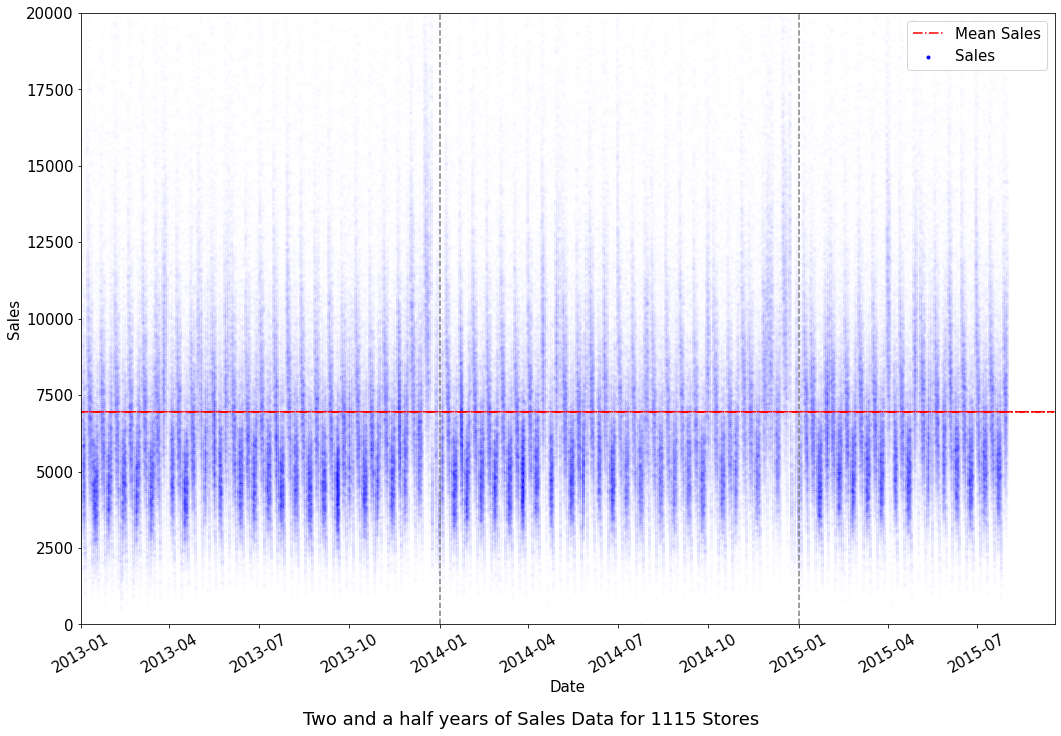

In [41]:
fig, ax = plt.subplots(figsize=(15,10))
opened = integrated.loc[integrated.Open==1]
mean_sales_vector = np.full(len(opened.Date), opened.Sales.mean())
all_dates = pd.concat([opened.Date, test_data.Date])
extended_sales_vector = np.full(len(all_dates), opened.Sales.mean())
ax.scatter(opened.Date, opened.Sales, alpha=0.002,c='b',marker='.',label='Sales')
ax.plot(all_dates, extended_sales_vector,label='Mean Sales',c='r',ls='-.')
ax.axvline(Timestamp(2014,1,1),c='grey',ls='--')
ax.axvline(Timestamp(2015,1,1),c='grey',ls='--')
ax.set_ylim(0,20000)
ax.set_xlim(Timestamp(2013,1,1),Timestamp(2015,9,18))
ax.set_ylabel('Sales')
ax.set_xlabel('Date')
leg = ax.legend(loc=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
ax.tick_params(axis='x', rotation=30)
fig.suptitle(f'Two and a half years of Sales Data for {len(store_data)} Stores',y=0)
fig.tight_layout()

plt.savefig('../figures/scatterdata.png')

Although there is a large amount of vertical variation within the data, the line is strikingly horizontal over time. This immediately suggests a simplest model, in which we predict the `Sales` of any given store on any day to be the mean of all known `Sales`.

$$\hat{S} = \mu_{\mathcal{S}}$$

where $\mathcal{S}$ is the set of known `Sales` values, $S_{it}$ is the particular known `Sales` value for a given `Store` $i$ on a `Date` $t$, and we write $\mu_{\mathcal{S}}$ for the mean of the set $\mathcal{S}$, such that $$\mu_{ \mathcal{S} } = \frac{1}{| \mathcal{S}|} \sum_{S_{it} \in \mathcal{S}} S_{it}$$

Note that while I try to use the appropriate notation [@KAbadirMagnus2002], the mathematics is here intended primarily as an exposition of the code, which is pragmatically focussed on optimizing a validated error score, rather than establishing any rigorous causal claim against a null hypothesis.


In [42]:
opened = integrated.loc[integrated.Open==1]
mean_sales_vector = np.full(len(opened.Sales), opened.Sales.mean())
print(f"""RMSPE of mean sales values as predictor of `Sales`:
{rmspe(opened.Sales, mean_sales_vector)}""")

RMSPE of mean sales values as predictor of `Sales`:
40.261795113999376


This gives us a RMSPE slightly over 40%.

### Personalized Models

Of course, we need not blindly consider all stores aggregated together, when we have precise data for each individual store. This suggests a better model:

$$\hat{S}(i) = \mu_{\mathcal{S}_{i}}$$

where $\mathcal{S}_{i} = \{ S_{it} : t \in [t_{0}, t_{1}] \} \subset \mathcal{S}$, 


In [43]:
mean_mapper = {}
for i in range(1,1115):
    mean_mapper[i] = opened.loc[opened.Store==i].Sales.mean()
opened['IndividualMeans'] = opened['Store'].map(mean_mapper)

In [44]:
print(f'RMSPE = {rmspe(opened.Sales, opened.IndividualMeans)}')

RMSPE = 15.503699843759986


Already we have a model which gives us a RMSPE of 15.4%.

Properly speaking we should validate this score on a hold-out sample before too much congratulating ourselves -- just because the overall aggregate mean of sales across all stores is stationary across time, there is no guarantee that the trend of any individual store will be so -- in which case our model will do somewhat worse on unseen data. But we will factor time effects into our model before going to the trouble of validating over a different time period.

### Seasonality and Trend

The other thing that is apparent from Figure 2 is a significant and repeated rise in sales just before the end of each year. This makes sense, in terms of extra shopping before the Christmas holidays. And it suggests that we pay closer attention to the performance of a particular Store not just in terms of its trend, but also in terms of its cyclic seasonal averages.

I therefore implemented two simple functions to find naive versions of seasonality and trend independently for each store: ; `find_trend()` uses ordinary least squares regression to find a line of best fit between a store's `Sales` and the `Date`'s `DayNumber` since the beginning of 2013; `get_averages()` finds the mean sales for every `Month` of the year, as well as for every `DayOfWeek`.

Mathematically, we use OLS to fit

$$ T_{i}(t) = \alpha_{i} + \beta_{i}t \approx S(i,t)$$

and we find

$$M_{i}(t) = M_{im} = \mu_{ \mathcal{S}_{im}}$$ for $t \in m$, where $m$ is the set of dates falling within a particular month, $\mathcal{S}_{im} = \{ S_{it} : t \in m \} \subset \mathcal{S}_{i}$, and $M_{im} \in \mathbb{R}$ is the monthly average for the store in question.


In [45]:
def find_trend(df):
    "Find line-of-best-fit for 'Sales ~ DayNumber'"
    
    dataset = df
    ## find `DayNumber` for each Date
    dataset['DayNumber'] = dataset.Date.dt.dayofyear \
                    + (dataset.Date.dt.year - 2013)*365
    ## only consider days when store is open
    dataset_open = dataset.loc[dataset.Open==1]
    
    naive_trend = {}
    dataset['NaiveTrend'] = 0
    
    ## iterate through Stores
    for i in dataset.Store.unique():
        naive_trend[i] = ols(formula='Sales~DayNumber', 
                        data=dataset_open.loc[dataset_open.Store==i]).fit()
        dataset['NaiveTrend'] = np.where(dataset.Store==i,
                        dataset.DayNumber*naive_trend[i].params['DayNumber'] \
                            + naive_trend[i].params['Intercept'],
                        dataset['NaiveTrend'])
        
    
    return dataset, naive_trend

In [46]:
def get_averages(df):
    """Get average Sales for various timeframes"""
    
    dataset = df
    t = dataset.NaiveTrend / dataset.NaiveTrend.mean()
    dataset['Month'] = dataset['Date'].dt.month
    mapper = {}
    length = ['Month','DayOfWeek']
    df_list = []
    df_store = {}
    
    ## iterate through Stores
    for store in dataset.Store.unique():
        df_store[store] = dataset.loc[dataset.Store==store]
        mapper[store] = {}
        
        ## iterate through list of time periods
        for l in length:
            df_store[store][f'AverageFor{l}'] = 0
            mapper[store][l] = {}
            
            ## iterate over unique months/days of week
            for i in dataset[l].unique():
                ## get mean Sales value
                mapper[store][l][i] = df_store[store].loc[
                    df_store[store][l]==i]['Sales'].mean()
                df_store[store][f'AverageFor{l}'] = np.where(
                    df_store[store][l]==i,
                    df_store[store][l].map(mapper[store][l]),
                    df_store[store][f'AverageFor{l}'])
                
        D = df_store[store].AverageForDayOfWeek \
                                    / df_store[store].AverageForDayOfWeek.mean()
        T = df_store[store].NaiveTrend / df_store[store].NaiveTrend.mean()
        df_store[store]['MTD'] = df_store[store].AverageForMonth * T * D
        df_list.append(df_store[store])
        
    dataset = pd.concat(df_list).sort_index()
    return dataset, mapper

As mentioned, 180 stores are missing data for the second half of 2014, so we begin by considering the eighteen months for which we have full data.


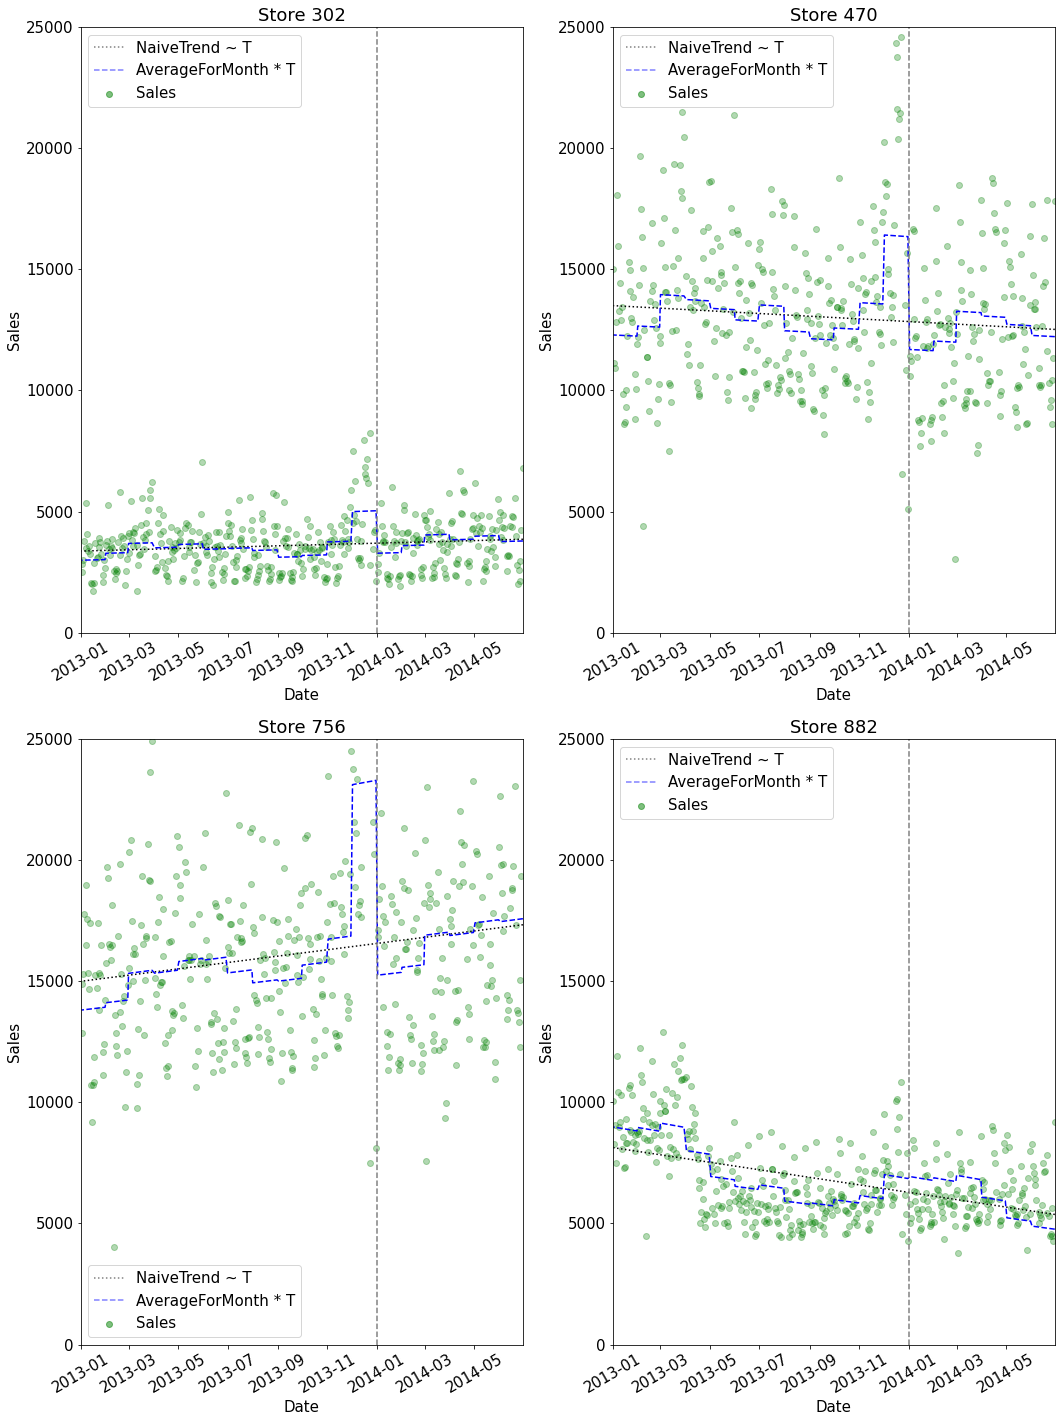

In [47]:

eighteen_months = integrated.loc[integrated.Date <= Timestamp(2014,6,30)]
eighteen_months = eighteen_months.loc[eighteen_months.Open==1]
eighteen_months, _ = find_trend(eighteen_months)
eighteen_months, _ = get_averages(eighteen_months)

fig, axs = plt.subplots(2,2,figsize=(15,20))
eg_stores = [302, 470, 756, 882]
for i in range(4):
    j = i//2
    k = i%2
    ax = axs[j][k]
    eg_store = eg_stores[i]
    eg = eighteen_months.loc[eighteen_months.Store == eg_store].sort_index()
    t = eg.NaiveTrend/eg.NaiveTrend.mean()
    ax.plot(eg.Date,eg.NaiveTrend,c='k',label='NaiveTrend ~ T',ls=':')
    ax.plot(eg.Date,eg.AverageForMonth*t,label='AverageForMonth * T',c='b',ls='--')
    ax.axvline(Timestamp(2014,1,1),c='grey',ls='--')
    ax.scatter(eg.Date, eg.Sales, alpha=0.3, c='g', label='Sales')
    ax.set_ylim(0,25000)
    ax.set_ylabel('Sales')
    ax.set_xlim(Timestamp(2013,1,1),Timestamp(2014,6,30))
    ax.set_xlabel('Date')
## https://stackoverflow.com/questions/12848808/set-legend-symbol-opacity-with-matplotlib
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(0.5)
    ax.set_title(f'Store {eg_store}')
    ax.tick_params(axis='x', rotation=30)
    
fig.tight_layout()
plt.savefig('../figures/trend_seasonality.png')

In Figure 3 we see eighteen months of sales visualized for four different stores, as well as a grey dotted line showing the linear trend of those sales, and a blue dashed line showing the shifting seasonal monthly average of sales for those eighteen months. Actually, what is shown is not the average itself, but the product of the monthly average $M_{im}$ of sales for a store $i$ in a month $m$ with the normalized trend given by $\bar{T_{i}}(t) = \frac{T_{i}(t)}{\mu_{\mathcal{T}_{i}}}$.

Thus our model could be something like $$\hat{S}(i,t) = M_{it}\bar{T_{i}}(t)$$

We see this gives quite a good fit, and that our suspicion was justified that we could not rely on the trend of any particular store to be flat. But before we train and validate a model in these terms, we also visualize the effect of considering the effect of the average of sales for a store on a particular day of the week, $$D_{i}(t) = \mu_{\mathcal{S}_{id}}$$ where $t \in d$, the set of all dates falling on some particular day of the week.


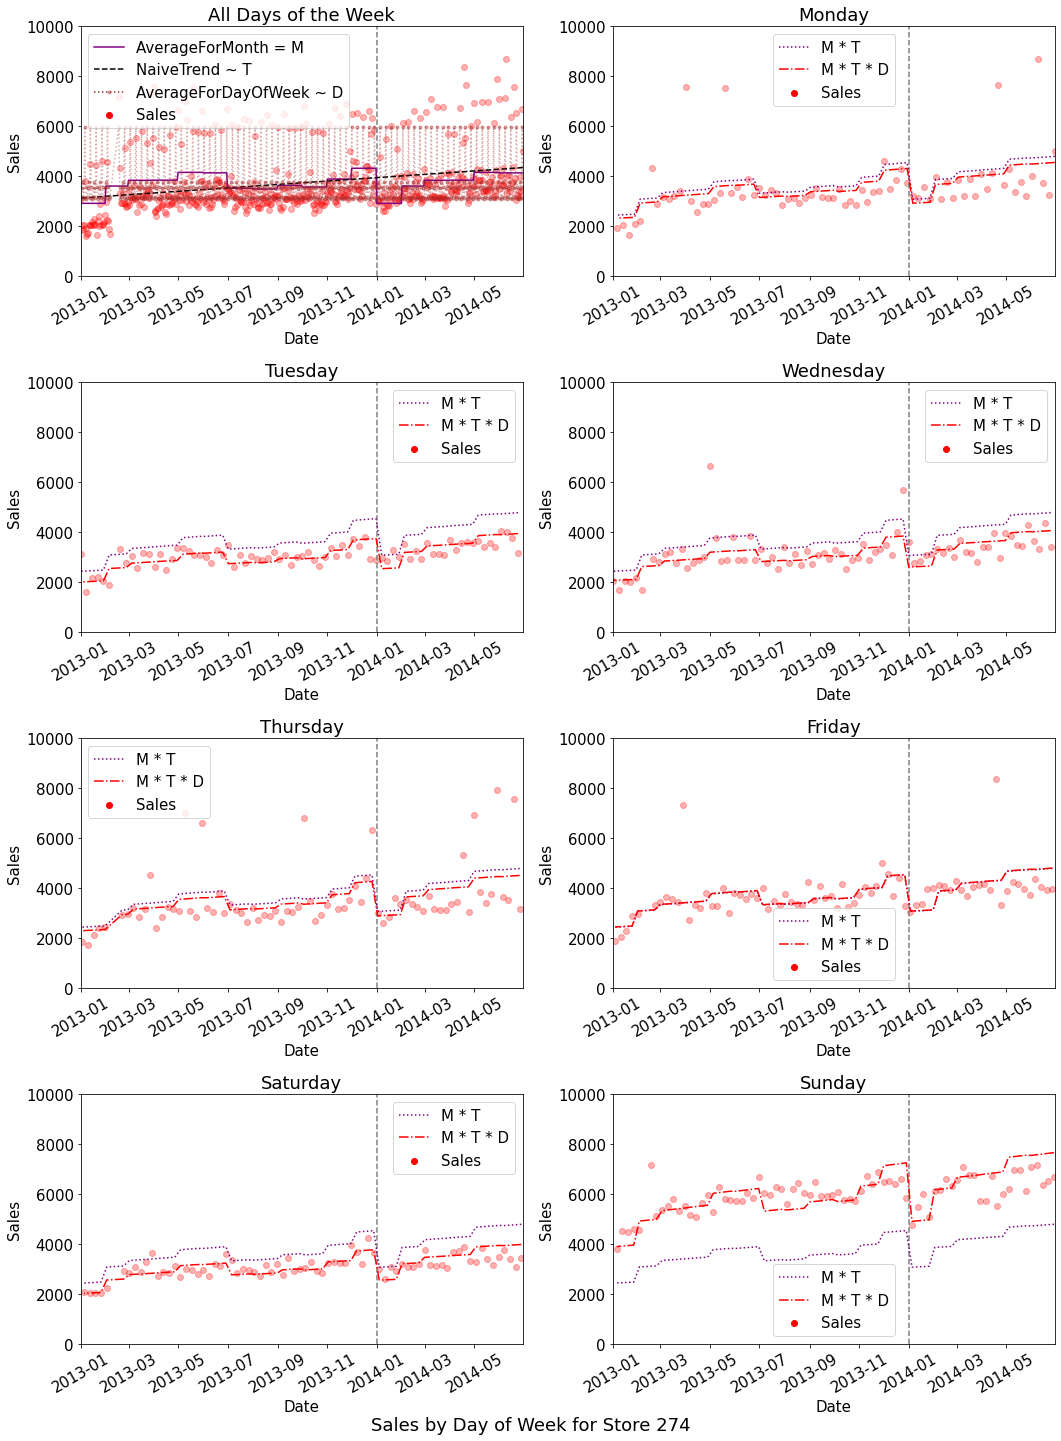

In [48]:

fig, axs = plt.subplots(4,2,figsize=(15,20))
days = calendar.day_name
eg_store = 274 #np.random.randint(1,n+1)
eg = eighteen_months.loc[eighteen_months.Store == eg_store].sort_index()
for i in range(0,8):
    j = i//2
    k = i%2
    ax = axs[j][k]
    if i == 0:
        df = eg
    else:
        df = eg.loc[eg.DayOfWeek == i]
    t = df.NaiveTrend/eg.NaiveTrend.mean()
    d = df.AverageForDayOfWeek/eg.AverageForDayOfWeek.mean()
    ax.scatter(df.Date, df.Sales, alpha=0.3, c='red', label='Sales')
    ax.axvline(Timestamp(2014,1,1),c='grey',ls='--')
    if i == 0:
        ax.plot(df.Date,df.AverageForMonth,label='AverageForMonth = M',c='purple',ls='-')
        ax.plot(df.Date,df.NaiveTrend,label='NaiveTrend ~ T', c='k',ls='--')
        ax.plot(df.Date,
                   df.AverageForDayOfWeek,
                   label='AverageForDayOfWeek ~ D',
                   c='brown',
                   ls=':',
                   marker='.',
                   alpha=0.4)
    else:
        ax.plot(df.Date,df.AverageForMonth*t,label='M * T',c='purple',ls=':')
        ax.plot(df.Date,df.AverageForMonth*t*d,label='M * T * D',c='red',ls='-.')
    ax.set_ylim(0,10000)
    ax.set_ylabel('Sales')
    ax.set_xlim(Timestamp(2013,1,1),Timestamp(2014,6,30))
    ax.set_xlabel('Date')
## https://stackoverflow.com/questions/12848808/set-legend-symbol-opacity-with-matplotlib
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    if i>0:
        ax.set_title(f'{days[i-1]}')
    else:
        ax.set_title('All Days of the Week')
    ax.tick_params(axis='x', rotation=30)
    
fig.suptitle(f'Sales by Day of Week for Store {eg_store}',y=0.01)
fig.tight_layout()

plt.savefig('../figures/daysofweek.png')

Again, we use the normalized version $\bar{D_{i}} = \frac{D_{i}}{\mu_{\mathcal{D}_{i}}}$, and then consider the product of daily and monthly cyclic patterns with the ongoing trend, which because of its curves we will here call

$$\zeta(i,t) = M_{it}\bar{T_{i}}\bar{D_{i}}$$

(In the code we simply add an extra feature to the dataframe named `MTD`).

It is clear from Figure 4 that also considering $\bar{D_{i}}$ improves the fit of our model -- at least in the case $i = 274$.

### Reproducible Code for Computing the Optimal Model

Thus far we have offered a visual suggestion that $\hat{S} = \zeta$ could be a good model, but nothing that could give any indication whether it might be an *optimal* model. To efficiently and persuasively compare and combine $\zeta(i,t)$ with the various $\delta_{F}(i,t) \mapsto \{ 0 , 1 \}$ (where $\delta_{F}$ is the binary mapping of a feature $F$ like `Promo` or `PublicHoliday`), we use the `Exhaustive Feature Selector` (imported as `EFS`) from the `mlxtend` library [@SRaschka2018] to suggest the best predictive models with 1, 2, and 3 (or indeed, however many we like) features.

`EFS` performs a brute-force evaluation of all feature subsets, selecting the one which scores best again the given error metric (in our case, RMSPE).



In [49]:
def suggest_best_predictors(fully_processed, max_features):
    """
    Use Exhaustive Feature Selection 
    to suggest best linear predictors 
    for our fully processed dataset
    """
    max_features = max_features
    efs, best = {}, {}
    best['data'] = fully_processed
    lr = LinearRegression()
    rmspe_scorer = make_scorer(rmspe, greater_is_better=False)
    for i in range(1, max_features+1):
        efs[i] = EFS(lr,
              min_features=i,
              max_features=i,
              scoring=rmspe_scorer, 
              print_progress=True,
              cv=0
              )
        efs[i].fit(fully_processed.drop(columns=['Sales']), 
                   fully_processed['Sales'], 
                   custom_feature_names=fully_processed.drop(
                       columns=['Sales']).columns)
        best[i] = efs[i].best_feature_names_
        
    keys = list(best.keys())
    keys.remove('data')
    best['max'] = max(keys)    
    return best

In [50]:
def fit_models(best_predictors):
    """
    Fit linear models and return results for given predictors.
    """
    fully_processed = best_predictors['data']
    
    max_features = best_predictors['max']
    
    formula, lm, results, coefs, RMSPE, mapper, models = {}, {}, {}, {}, {}, {}, {}

    for j in range(1, max_features+1):
        sum = ''
        for k, predictor in enumerate(best_predictors[j]):
            if k == 0:
                sum = f'Q("{predictor}")'
            else:
                sum = f'{sum} + Q("{predictor}")'

        formula[j] = f'Q("Sales") ~ {sum} '

    for j in range(1, max_features+1):

        lm[j] = ols(formula[j], fully_processed).fit()
        coefs[j] = lm[j].params
        RMSPE[j] = rmspe(fully_processed.Sales, lm[j].predict())
        
    results = pd.DataFrame(coefs)

    for j in range(1, max_features+1):
        coefs[j] = lm[j].params
    results = pd.DataFrame(coefs).transpose()
    results['RMSPE'] = pd.Series(RMSPE, 
                                 index=list(range(1,max_features+1)), 
                                 name='RMSPE')
    results.index.name = "Features"
    
    for col in list(results.columns):
        if col[0]=='Q':
            mapper[col] = col[3:-2]
    results.rename(columns=mapper,inplace=True)

    for i in range(len(results)):
        models[i+1] = dict(results.iloc[i])
        models[i+1].pop('RMSPE')
        nan_keys = []
        for key in models[i+1].keys():
            if str(models[i+1][key]) == 'nan':
                nan_keys.append(key)
        for key in nan_keys:
            models[i+1].pop(key)
    
    return models, results

First though we need to preprocess our training sample: exclude dates where stores are closed, create dummy variables, and drop unnecessary columns.


In [51]:
def only_open(df):
    """Only consider data from when store is open"""
    return df.loc[df.Open==1]

In [52]:
def create_dummies(df):
    """Create dummy variables"""
    
    dataset = df
    dataset['PublicHoliday'] = np.where(dataset.StateHoliday == 'a', 1, 0)
    dataset['EasterHoliday'] = np.where(dataset.StateHoliday == 'b', 1, 0)
    dataset['ChristmasHoliday'] = np.where(dataset.StateHoliday == 'c', 1, 0)

    for x in dataset.StoreType.unique():
        dataset[f'Type{x.capitalize()}'] = np.where(dataset.StoreType == x, 1, 0)

    for x in dataset.Assortment.unique():
        dataset[f'Assortment{x.capitalize()}'] = np.where(dataset.Assortment == x, 1, 0)
    
    return dataset

In [53]:
def streamline(df, unnecessary_cols):
    """Streamline df for ExhaustiveFeatureSelector by removing unnecessary columns"""
    return df.drop(columns=unnecessary_cols)

In [54]:
def prepare_training_set(start_date, end_date, unnecessary_cols):
    """Prepare training set for given dates with single function"""
    dataset = integrated.loc[integrated.Date >= start_date]\
                    .loc[integrated.Date <= end_date]
    dataset = only_open(dataset)
    dataset, trend = find_trend(dataset)
    dataset, mapper = get_averages(dataset)
    dataset = create_dummies(dataset)
    dataset = streamline(dataset, unnecessary_cols)
    return dataset, trend, mapper

Similarly we need to prepare the data for our validation dataset, making sure not to compute the averages and trend directly (thus invalidating our claim that we are forecasting the unknown future), but rather impute them on the assumption that they will be the same as those for our sampled training set.



In [55]:
def extend_trend(naive_trend, validation_set):
    """Extend (naively extracted) trend from training set to validation set"""
    validation_set['DayNumber'] = validation_set.Date.dt.dayofyear \
                    + (validation_set.Date.dt.year - 2013)*365
    validation_set['NaiveTrend'] = 0
    for i in validation_set.Store.unique():
        validation_set['NaiveTrend'] = np.where(validation_set.Store==i,
                                        validation_set.DayNumber*naive_trend[i].params['DayNumber'] \
                                         + naive_trend[i].params['Intercept'],
                                         validation_set['NaiveTrend'])
    return validation_set

In [56]:
def impute_averages(validation_set, averages_mapper):
    """Impute averages from training set to validation set"""

    mapper = averages_mapper
    validation_set['Month'] = validation_set['Date'].dt.month
    
    length = ['Month','DayOfWeek']
    df_list = []
    df_store = {}
    
    ## iterate through Stores
    for store in validation_set.Store.unique():
        df_store[store] = validation_set.loc[validation_set.Store==store]
        
        ## iterate through list of time periods
        for l in length:
            df_store[store][f'AverageFor{l}'] = 0
            
            ## iterate over unique months/days of week
            for i in validation_set[l].unique():
                ## get mean Sales value
                df_store[store][f'AverageFor{l}'] = np.where(
                    df_store[store][l]==i,
                    df_store[store][l].map(mapper[store][l]),
                    df_store[store][f'AverageFor{l}'])
                
        D = df_store[store].AverageForDayOfWeek \
                                    / df_store[store].AverageForDayOfWeek.mean()
        T = df_store[store].NaiveTrend / df_store[store].NaiveTrend.mean()
        df_store[store]['MTD'] = df_store[store].AverageForMonth * T * D
        df_list.append(df_store[store])
        
    validation_set = pd.concat(df_list).sort_index()
    
    return(validation_set)

In [57]:
def predict_sales(model, row):
    """Apply model to row to predict sales"""
    predictors = list(model.keys())
    predictors.remove('Intercept')
    prediction = model['Intercept']
    for p in predictors:
        prediction += row[p] * model[p]
    return prediction

In [58]:
def prepare_validation_set(start_date, end_date, training_set, mapper, training_trend, unnecessary):
    """Prepare validation dataset"""
    validation_set = integrated.loc[start_date <= integrated.Date]\
                                .loc[integrated.Date <= end_date]
    validation_sales = validation_set.loc[validation_set['Open']==1]['Sales']
    validation_set = validation_set.drop(columns='Sales')
    validation_set = extend_trend(training_trend, validation_set)
    validation_set = impute_averages(validation_set, mapper)
    validation_set = validation_set.loc[validation_set['Open']==1]
    validation_set = create_dummies(validation_set)
    validation_set = validation_set.drop(columns=unnecessary)   
    
    return validation_set, validation_sales

In [59]:
def validate_predictions(model, validation_set, validation_sales):
    """Return RMSPE scores on validation data for prediction model"""
    predictions = validation_set.apply(lambda x: predict_sales(model, x),axis=1)
    return rmspe(validation_sales, predictions)

In [60]:

def pandas_df_to_markdown_table(df):
    "Round table figures and print as markdown table"

    df = df.round(3)
    df = df.reset_index()
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    print(df_formatted.to_csv(sep="|", index=False))

## Results

### First Iteration: First Eighteen Months

We first train a model on the first eighteen months of data, and validate it on the following six months. If the validation confirms the adequacy of our model, then we can use our estimated values to fill in the six month gap for the 180 stores that we discovered in our data cleaning stage are missing data for those dates.


In [61]:
unnecessary = [
    'Store',
    'Customers',
    'Open',
    'StateHoliday',
    'StoreType',
    'Assortment',
    'CompetitionDistance',
    'CompetitionDate',
    'Promo2Date',
    'PromoInterval',
    'Month',
    'DayOfWeek',
    'DayNumber',
    'NaiveTrend', 
    'AverageForMonth', 
    'AverageForDayOfWeek',
]

In [62]:
start_date = Timestamp(2013,1,1)
end_date = Timestamp(2014,6,30)
processed_18, trend, mapper = prepare_training_set(start_date, end_date, unnecessary)
v_set, v_sales = prepare_validation_set(
    Timestamp(2014,7,1), Timestamp(2014,12,31), 
    processed_18, mapper, trend, unnecessary)
processed_18 = streamline(processed_18, ['Date'])
best = suggest_best_predictors(processed_18, 3)
models, results = fit_models(best)
v_score = {}

Features: 364/364

In [63]:
for i in models.keys():
    v_score[i] = validate_predictions(models[i], v_set, v_sales)
results['Val. RMSPE'] = pd.DataFrame(v_score, index=['Score']).T
pandas_df_to_markdown_table(results)

Features|Intercept|MTD|Promo|TypeB|RMSPE|Val. RMSPE
---|---|---|---|---|---|---
1|58.591|0.991|||7.443|13.754
2|-587.809|0.965|1914.375||5.473|9.538
3|-580.602|0.963|1916.183|232.116|5.465|9.518



Our method suggests three possible models, all of which seem to hold up on validation. 

### Second Iteration: Impute Estimates and Validate Further

Inspection of the code suggests that I chose the single-feature model, and the reason will be because of computational efficiency: rerunning the notebook as I worked on the analysis would be quicker with a simpler model.

Also, using the model to impute estimates for the missing six months is a non-trivial exercise. Before doing so, we must first generate the relevant data for those dates, since details like which days those 180 stores were open for during that time period, and whether or not they ran a `Promo` are all unknown.I estimated answers by saying that the pattern was identical as for the same day in the same week the previous year.


In [64]:
## Impute model estimates for missing six months

## generate dates
d_range = pd.date_range(Timestamp(2014,7,1),Timestamp(2014,12,31))

## find out details (ie. holiday, day of week) of dates from those with data
six_months = integrated.loc[integrated.Date >= Timestamp(2014,7,1)]\
                    .loc[integrated.Date <= Timestamp(2014,12,31)]
details, info, df = {}, {}, {}
for d in d_range:
    details[d] = {}
    details[d]['StateHoliday'] = six_months.loc[six_months.Date==d].StateHoliday.describe().top
    details[d]['SchoolHoliday'] = six_months.loc[six_months.Date==d].SchoolHoliday.median()
    details[d]['DayOfWeek'] = six_months.loc[six_months.Date==d].DayOfWeek.median()

## we will assume that stores with no data for the second half of 2014,
## ... had exactly the same pattern of being `Open` and doing a `Promo` as they did the year before
i = 0
for store in stores:
    info[store] = {}
    store_df = integrated.loc[integrated.Store == store]
    store_df = store_df.loc[store_df.Date.dt.year == 2013]
    for d in d_range:
        info[store][d] = {}
        day = d.dayofweek
        week = d.week
        last_year = store_df.loc[(
            store_df.Date.dt.week == week) & (store_df.Date.dt.dayofweek == day)]
        info[store][d]['Open'] = last_year.Open.values[0]
        info[store][d]['Promo'] = last_year.Promo.values[0]
        
        df[i] = {'Store': store,
                'Date': d,
                'Open': info[store][d]['Open'],
                'Promo': info[store][d]['Promo'],
                'StateHoliday': details[d]['StateHoliday'],
                'SchoolHoliday': details[d]['SchoolHoliday'],
                'DayOfWeek': details[d]['DayOfWeek']}
        i += 1

estimates = pd.DataFrame(df).T
estimates = extend_trend(trend, estimates)
estimates = impute_averages(estimates, mapper)
estimates['Sales'] = estimates.apply(lambda x: predict_sales(models[1], x), axis=1)
estimates['Sales'] = np.where(estimates.Open==0, 0, estimates['Sales'])

storetype, assortment, promo2 = {}, {}, {}
for store in stores:
    storetype[store] = store_data.loc[store_data.Store == store].StoreType.values[0]
    assortment[store] = store_data.loc[store_data.Store == store].Assortment.values[0]
    promo2[store] = store_data.loc[store_data.Store == store].Promo2.values[0]

estimates['StoreType'] = estimates.Store.map(storetype)
estimates['Assortment'] = estimates.Store.map(assortment)
estimates['Promo2'] = estimates.Store.map(promo2)

integrated = pd.merge(integrated,estimates,how='outer').sort_index()

Once the estimates have been imputed, we perform the second iteration of our method, this time training on all the (now synthetically complete) data from the first two years and three months, and validating on the subsequent three months.


In [65]:
## validate estimates
start_date = Timestamp(2013,1,1)
end_date = Timestamp(2015,3,31)
processed_filled, trend, mapper = prepare_training_set(start_date, end_date, unnecessary)
v_set2, v_sales2 = prepare_validation_set(
    Timestamp(2015,4,1), Timestamp(2015,6,30), 
    processed_filled, mapper, trend, unnecessary)
processed_filled = streamline(processed_filled, ['Date'])
best = suggest_best_predictors(processed_filled, 3)
models, results2 = fit_models(best)
v_score = {} 
for i in models.keys():
    v_score[i] = validate_predictions(models[i], v_set2, v_sales2)
results2['Val. RMSPE'] = pd.DataFrame(v_score, index=['Score']).T
pandas_df_to_markdown_table(results2)

Features: 364/364

Features|Intercept|MTD|Promo|TypeB|RMSPE|Val. RMSPE
---|---|---|---|---|---|---
1|57.769|0.991|||8.338|5.575
2|-584.408|0.967|1826.938||6.011|3.879
3|-576.754|0.965|1828.743|231.384|6.003|3.868



Our attempt to use estimated data to complete the set on which we train our models seems to have worked incredibly well. The unseen validation set now has an error of less than 5% if we take the two-variable model.

It does seem surprising that the RMSPE on the unseen validation data is significantly better than the RMSPE on the training data itself, but this can be explained by the fact that we are validating on data near the middle of the year (from the start of April through until the end of June, in this case), and much of the error will come from the end-of-year spike (as suggested by Figure 3). 

### Third Iteration: Hyper-Personalized Models

At this point we have a fairly good model:

$$\hat{S} = \alpha + \beta\zeta_{i} + \gamma\delta_{P} \pm e = S $$ 

with $\mathbb{E}(| e |) < \frac{1}{10}S$.

We now improve it further, by leaning further in to the initial insight that we should consider each store individually. We might call this our *personalization thesis*.

For this final iteration of model development, we use `EFS` to find a best two-feature additive linear model for each store independently:

$$\Omega_{i} = \alpha_{i} + \beta_{i}f_{i} + \gamma_{i}g_{i} \pm e_{i} = S_{i} $$

such that we minimize $\mathbb{E}(| e_{i} |)$, with any two features $f_{i}, g_{i} \in \{ \zeta_{i}, \delta_{P}, \delta_{P_{2}}, \delta_{H_{P}}, \delta_{H_{S}}, \delta_{H_{E}}, \delta_{H_{C}} \}$.

We then create a new feature column `IndividualModel2` with the predicted values of that model for each date and store. And then we run `EFS` again, including all the stores together, to evaluate the errors and check whether a better score can be found by including any other feature with `IndividualModel2`.



In [66]:
start, end = Timestamp(2013,1,1), Timestamp(2015,5,31)
training_set = integrated.loc[integrated.Date >= start]\
                    .loc[integrated.Date <= end]
validation_set = integrated.loc[integrated.Date >= Timestamp(2015,6,1)]\
                    .loc[integrated.Date <= Timestamp(2015,7,31)]
df_store, vdf_store, trend_store = {}, {}, {}
best_predictors, models_store, results_store = {}, {}, {}
processed_3, trend, mapper = prepare_training_set(start, end, unnecessary)
v_set3, v_sales3 = prepare_validation_set(
    Timestamp(2015,6,1), Timestamp(2015,7,31),
    processed_3, mapper, trend, unnecessary)

In [67]:
## for each store we reduce the training_data and validation_set
## ...to that relevant to the store, and then do exhaustive feature selection
## ... to suggest the best predictors 
processed_3.drop(columns='Date', inplace=True)
for store in range(1,n+1):
    df_store[store] = processed_3.loc[training_set.Store == store]
    vdf_store[store] = v_set3.loc[validation_set.Store == store]
    best_predictors[store] = suggest_best_predictors(df_store[store], 2)
    models_store[store], results_store[store] = fit_models(best_predictors[store])

Features: 91/91

In [68]:
predictions = {}
for store in training_set.Store.unique():
    for i in range(1,3):
        df_store[store][f'IndividualModel{i}'] = df_store[store].apply(
            lambda x: predict_sales(models_store[store][i], x), axis=1)
        vdf_store[store][f'IndividualModel{i}'] = vdf_store[store].apply(
            lambda x: predict_sales(models_store[store][i], x), axis=1)

In [69]:
df_list, vdf_list = [], []
for store in training_set.Store.unique():
    df_list.append(df_store[store])
    vdf_list.append(vdf_store[store])
ind_training = pd.concat(df_list)
ind_valid = pd.concat(vdf_list).drop(columns='Date')
## v_set3.drop(columns='Date', inplace=True)
for i in range(1,3):
    processed_3[f'IndividualModel{i}'] = ind_training[f'IndividualModel{i}']
    v_set3[f'IndividualModel{i}'] = ind_valid[f'IndividualModel{i}']

In [70]:

best3 = suggest_best_predictors(processed_3, 3)
models, results3 = fit_models(best3)
v_score = {} 
for i in models.keys():
    v_score[i] = validate_predictions(models[i], v_set3, v_sales3)
results3['Val. RMSPE'] = pd.DataFrame(v_score, index=['Score']).T
pandas_df_to_markdown_table(results3)

Features: 560/560

Features|Intercept|EasterHoliday|IndividualModel2|Promo|RMSPE|Val. RMSPE
---|---|---|---|---|---|---
1|0.0||1.0||4.803|2.566
2|0.382||0.998|23.864|4.798|2.558
3|0.356|-89.409|0.998|23.841|4.797|2.558



This does indeed give improved model performance, and it seems likely our model would perform very well against the test data.

## Interpretation and Conclusions

More interesting though than just an improved RMSPE score, is that we can now interrogate the details of each store's best-performing `IndividualModel2` ($\Omega_{i}$) to see what, if anything, the specific details may reveal. Indeed, our method has also yielded an `IndividualModel1`, a best single-feature model for each store. 

This means we can see for each store which feature was the most powerful predictor, and which was second. We tabulate the aggregate scores in Table 4 (leaving out the two-feature case from any models which failed to improve the RMSPE score by more than 0.1, meaning the optimum model had already been found).


In [71]:
improvements = {}
for store in range(1, n+1):
    improvements[store] = results_store[store].RMSPE[1]\
                    - results_store[store].RMSPE[2]

improvement = pd.DataFrame(improvements, index= ['Improvement']).T
no_improvement = improvement.loc[improvement.Improvement<0.1].index

predictor_scores = {}
for i in range(1,3):
    predictor_scores[i] = {}
for store in range(1, n+1):
    for i in range(1, 3):
        for p in best_predictors[store][i]:
            if not (store in no_improvement and i == 2):
                try:
                    predictor_scores[i][p] += 1
                except:
                    predictor_scores[i][p] = 1

with_one = pd.DataFrame(predictor_scores[1],index=['OnePredictor']).T
with_two = pd.DataFrame(predictor_scores[2],index=['TwoPredictors']).T
count_predictors = with_two.join(with_one)
count_predictors.fillna(0,inplace=True)
count_predictors['Totals'] = count_predictors.OnePredictor \
                                + count_predictors.TwoPredictors
count_predictors = count_predictors.astype(int)

In [72]:
pandas_df_to_markdown_table(count_predictors.T)

index|Promo|MTD|SchoolHoliday|PublicHoliday|ChristmasHoliday|EasterHoliday
---|---|---|---|---|---|---
TwoPredictors|1020|1020|10|19|1|2
OnePredictor|755|359|0|1|0|0
Totals|1775|1379|10|20|1|2



To our surprise, we find that in the `OnePredictor` case, for more than half of the stores the most powerful predictive feature was simply whether or not there was a `Promo` on that day -- rather than the `MTD` $\zeta$ value we have calculated. 

We conclude by noting that our models have been simple additive combinations of features -- although those features have included processed multiplicative products. If we needed to try and improve our model still further, we should include the product $\zeta$ and $\delta_{P}$, and perhaps also their products with `StateHoliday`. 

We also note that because we treated each store individually, the general effect of features particular to stores is hidden: that is, we see `Promo` and the various types of `StateHoliday` showing up in our final analysis because they are features of a particular `Date`; and we do not see `StoreType` or `Assortment` because when a store is considered individually those features are constant. Also, we have not in the end considered the effect of `Promo2` and `CompetitionDistance`, since their effect is delayed in time and thus complex to detect.

## References